In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display


# Options

In [2]:
regions = ['SEA']
months = ['Jan','Apr','July'] #options are Jan, Apr, July, Oct
time = '20160'
pulse_size = '2x'
#compare_2x = True #True allows for comparison to the 2x simulation to see the performance of the GF; False just creates a new GF
#global_mean = True #False turns on a spatially explicit version with lat and lon; True turns on a global weighted mean
length_simulation = 60 #days
diagnostic = 'SpeciesConc'


## Import data

In [3]:
dict_conc = {}
dict_emis = {}
for r in regions:
    for m in months:
        print(r)
        #2x pulse for GF
        dict_conc[r + '_' + m] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/{r}/{m}/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords')
        #2x pulse for GF
        dict_emis[r + '_' + m] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_{pulse_size}_pulse/{r}/{m}/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords')


for m in months:
    dict_conc[f'base_{m}'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/{m}/mod_output/GEOSChem.SpeciesConc.{time}*', combine = 'by_coords', engine = 'netcdf4')
    dict_emis[f'base_{m}'] = xr.open_mfdataset(f'../GCrundirs/IRF_runs/stretch_base/template/{m}/mod_output/GEOSChem.Emissions.{time}*', combine = 'by_coords', engine = 'netcdf4')

SEA
SEA
SEA


dict_conc['all_countries_summed'] = dict_conc['Indo'] + dict_conc['Malay'] + dict_conc['Viet'] + dict_conc['Cambod']

In [4]:
#shift our time so that it is halfway through the day to represent the daily mean
for i in dict_conc.keys():
    utils.switch_conc_time(dict_conc[i])

In [5]:
for i in dict_conc.keys():
    dict_conc[i]['time'] = np.arange(0,len(dict_conc[i]['time']))
    dict_emis[i]['time'] = np.arange(0,len(dict_emis[i]['time']))

In [6]:
ds_conc = xr.concat([dict_conc[r] for r in dict_conc.keys()], pd.Index([r for r in dict_conc.keys()], name='run'))
ds_emis = xr.concat([dict_emis[r] for r in dict_emis.keys()], pd.Index([r for r in dict_emis.keys()], name='run'))

In [7]:
ds_conc['BC_total'] = ds_conc['SpeciesConc_BCPI'] + ds_conc['SpeciesConc_BCPO']
utils.combine_BC(ds_emis)

In [8]:
ds_emis = utils.fix_area_ij_latlon(ds_emis)
ds_conc= utils.fix_area_ij_latlon(ds_conc)

## Add height to data

In [9]:
height = pd.read_excel('gc_72_estimate.xlsx', index_col = 0)

In [10]:
height = height.reindex(index=height.index[::-1])

In [11]:
height_ds = height.diff().dropna().to_xarray().rename({'L':'lev'})
height_ds = height_ds.rename({'Altitude (km)':'dz'}) 
height_ds['dz']*=1e3 #convert to meters
height_ds['dz'].attrs = {'units':'m'}

In [12]:
#ds_emis = xr.merge([ds_emis, height_ds], join = 'inner')
ds_conc = xr.merge([ds_conc, height_ds], join = 'inner')

In [13]:
sec_day = 86400

## Define our Conc Difference and Initial Forcing

In [14]:
poll_name = 'BC_total'
dt = 1 #day

In [15]:
ds_emis = ds_emis.isel(lev = -1) #select surface since we only have surface emissions

In [16]:
#regions = ds_conc.run.values[:-1]

In [17]:
f0 = {}
for r in regions:
    for m in months:
        f0[r + '_' + m] = (ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = r + '_' + m) - 
                ds_emis['EmisBC_Total'].weighted(ds_emis['area'].fillna(0)).sum(dim = ['lat','lon']).sel(run = f'base_{m}')).values[0]


In [18]:
#calculate the Green's function as dc/f0
G_dict = {}
G_dict_gmean = {}
regions = ['SEA']

for r in regions:
    for m in months:
        G_dict[r + '_' + m] = (ds_conc.sel(run =r + '_' + m)-ds_conc.sel(run =f'base_{m}'))['BC_total']/f0[r + '_' + m]
        G_dict_gmean[r + '_' + m] = (ds_conc.sel(run =r + '_' + m)-ds_conc.sel(run =f'base_{m}'))['BC_total'].weighted(
            ds_conc['area'].sel(run = f'base_{m}').fillna(0)*ds_conc['dz'].fillna(0)).mean(['lat','lon','lev'])/f0[r + '_' + m]


In [19]:
#convert to datasets, calculate mean GF
G = xr.concat([G_dict[r] for r in G_dict.keys()], pd.Index([r for r in G_dict.keys()], name='run'))
G_mean = xr.concat([G_dict_gmean[r] for r in G_dict_gmean.keys()], pd.Index([r for r in G_dict_gmean.keys()], name='run'))


## Save out the Green's function

In [82]:
G.to_netcdf(f'Outputs/G_all_locs_all_times_{poll_name}.nc4')

## Global mean GF Plot

In [ ]:
G_mean.mean(dim = 'run').plot(label = 'Mean')
G_mean.sel(run = 'SEA_July').plot(label = 'July')
G_mean.sel(run = 'SEA_Apr').plot(label = 'Jan')
G_mean.sel(run = 'SEA_Jan').plot(label = 'Apr')
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title("Pulse from Southeast Asia")
plt.savefig('IGAC/global_mean_SEA_month_comp.png', dpi = 250, bbox_inches = 'tight')

Text(0.5, 1.0, '')

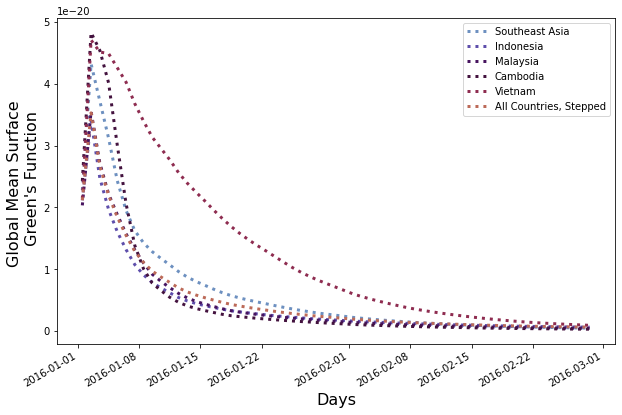

In [35]:
fig, ax = plt.subplots(figsize = [10,6])
color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in regions[:-1]:
    c = next(color)
    
    G_mean.mean(dim = 'run').plot(label = utils.names_dict[r], linestyle = 'dotted', linewidth = 3, c = c)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title('')
#plt.savefig('figures/G.png', dpi = 200, bbox_inches = 'tight')

Text(0.5, 1.0, '')

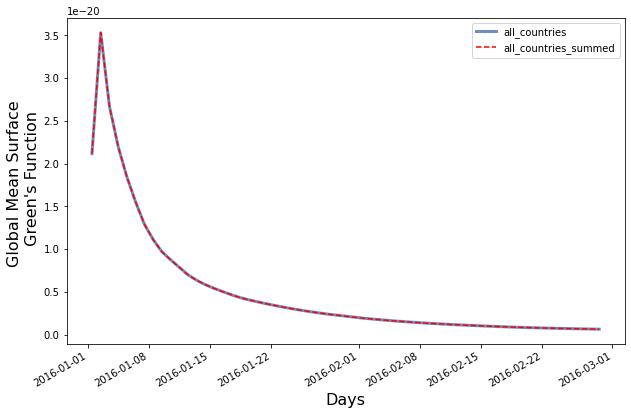

In [25]:
fig, ax = plt.subplots(figsize = [10,6])
color = iter(cm.twilight(np.linspace(.2, .9, 8)))
for r in ['all_countries','all_countries_summed']:
    c = next(color)
    if 'summed' in r:
        G_mean.sel(run = r).plot(label = r, linestyle = 'dashed', c= 'red')
    else:
        G_mean.sel(run = r).plot(label = r, linestyle = 'solid', linewidth = 3, c = c)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title('')
#plt.savefig('figures/G.png', dpi = 200, bbox_inches = 'tight')

## Location Average test 

In [55]:
ds_emis = ds_emis.rename({'time':'tp'})

In [56]:
ds_emis = ds_emis.assign_coords(tp = np.arange(0,len(ds_emis['tp'])))

In [58]:
ds_emis_gmean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    ds_emis_gmean[r] = (ds_emis.sel(run = r)-
                 ds_emis.sel(run = 'base'))['EmisBC_Total'].weighted(
    (ds_emis['area'].fillna(0)).sel(run = 'base')).sum(dim = ['lat','lon']).compute()


In [59]:
G_loc = G.sel(lat = 25, lon = 114, method = 'nearest').isel(lev = 0)

In [66]:
out_mean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    out_mean[r] = utils.convolve_global_mean(G_loc.sel(run = r).compute(), ds_emis_gmean[r], dt = dt, time_dim = 'time')

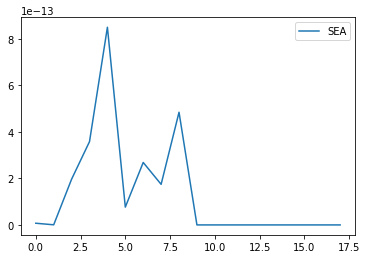

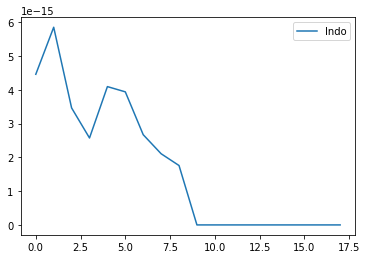

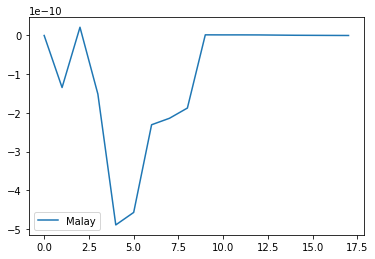

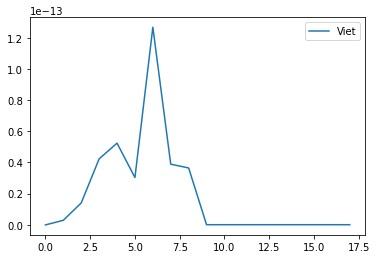

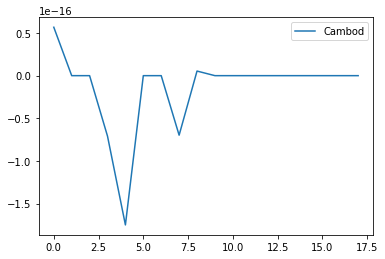

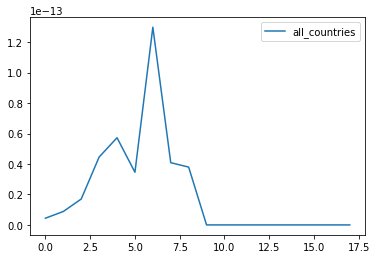

In [69]:
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    fig, ax = plt.subplots()
    plt.plot(out_mean[r], label = r)
    plt.legend()

## Global Mean Test

In [71]:
out_gmean = {}
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    out_gmean[r] = utils.convolve_global_mean(G_mean.sel(run = r).compute(), ds_emis_gmean[r], dt = dt, time_dim = 'time')

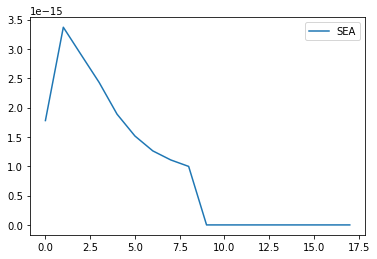

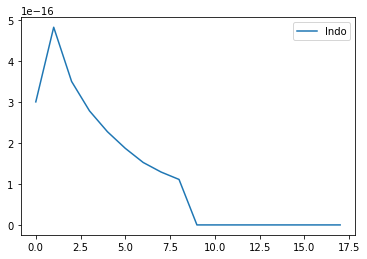

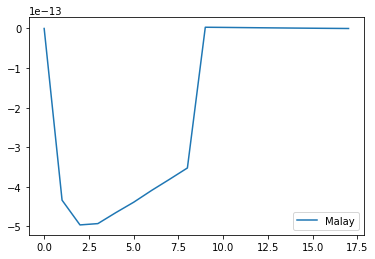

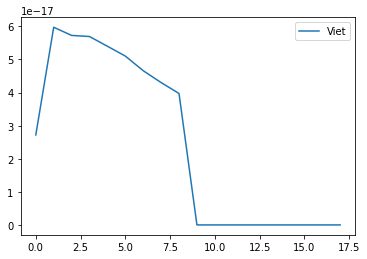

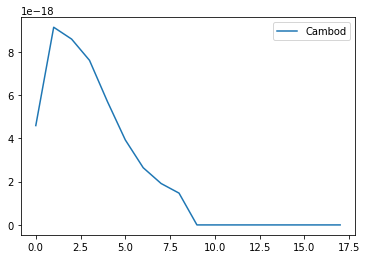

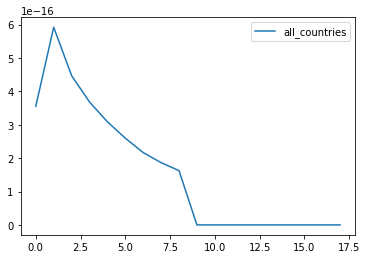

In [75]:
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries']:
    fig, ax = plt.subplots()
    plt.plot(out_gmean[r], label = r)
    plt.legend()

# Plots

Text(0.5, 1.0, '')

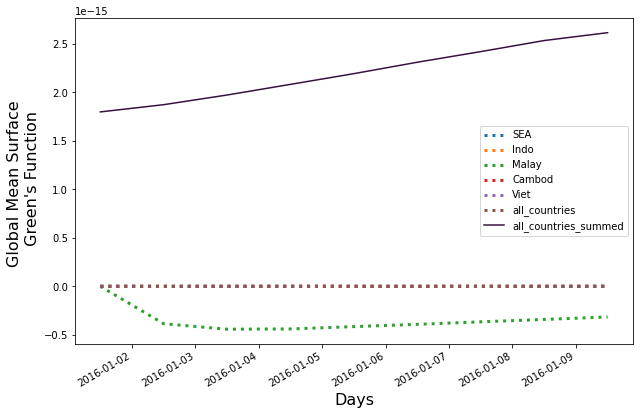

In [100]:
G_mean

<xarray.DataArray 'BC_total' (run: 7, time: 9)>
dask.array<concatenate, shape=(7, 9), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T12:00:00 ... 2016-01-09T12:00:00
  * run      (run) object 'SEA' 'Indo' ... 'all_countries_summed'

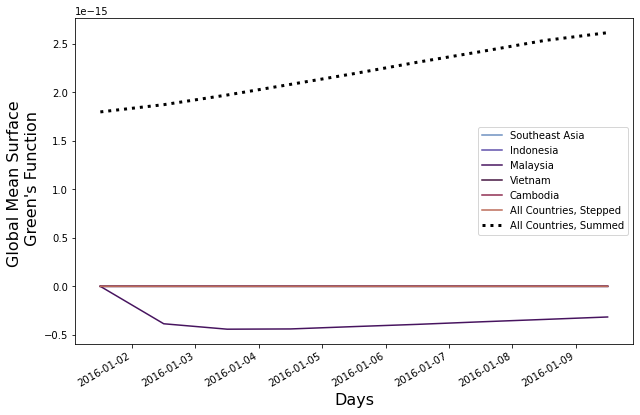

In [99]:

fig, ax = plt.subplots(figsize = [10,6])
color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo', 'Malay', 'Viet', 'Cambod', 'all_countries', 'all_countries_summed']:
    c = next(color)
    if r != 'all_countries_summed':
        G_mean.sel(run = r).plot(label = utils.names_dict[r], linestyle = 'solid', c= c)
    else:
        G_mean.sel(run = r).plot(label = 'All Countries, Summed', linestyle = 'dotted', c= 'black', linewidth = 3)
plt.legend()
plt.xlabel('Days', fontsize = 16)
plt.ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
plt.title('')
plt.savefig('figures/G_spatial_comp.png', dpi = 200, bbox_inches = 'tight')

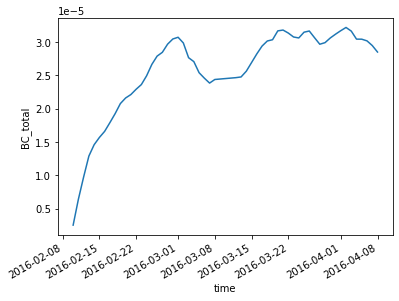

In [113]:
r = 'all_countries'
((utils.global_w_mean(ds_conc.sel(run = r + '_2x').fillna(0), poll_name)-utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name))*1e9).plot()

In [ ]:
fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize = [20,4])

color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    ax1.plot((utils.global_w_mean(ds_conc.sel(run = r + '_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name))*1e9, color = c)
    ax1.plot(out_gmean[r]*1e9, label = utils.names_dict[r], linestyle = ':', linewidth = 3, color = c)

#ax1.legend(fontsize = 12)
ax1.set_ylabel('Global Mean Concentration (ppt)', fontsize = 18)
ax1.set_xlabel('Days', fontsize = 18)
ax1.set_xlim(0,60)


color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    ax2.plot((ds_conc.sel(run = r + '_2x')-ds_conc.sel(run = 'base')).sel(lat = 25, lon = 114, method = 'nearest').fillna(0).isel(lev = 0)['BC_total']*1e9, 
             color = c)
    ax2.plot(out_mean[r]*1e9, label = utils.names_dict[r], linestyle = ':', linewidth = 3, color = c)

#ax2.legend(fontsize = 12)
ax2.set_xlim([0,50])
ax2.set_xlim(0,60)
ax2.set_ylabel('Location Specific Concentration (ppt)', fontsize = 18)
ax2.set_xlabel('Days', fontsize = 18)
ax2.set_yscale("log")  


color = iter(cm.twilight(np.linspace(.2, .9, 7)))
for r in ['SEA', 'Indo']:
    c = next(color)
    if r != 'all_countries_summed':
        G_mean.sel(run = r).plot(ax = ax3, label = utils.names_dict[r], linestyle = 'solid', c= c)
    else:
        G_mean.sel(run = r).plot(ax = ax3, label = 'All Countries, Summed', linestyle = 'dotted', c= 'black', linewidth = 3)
ax3.legend()
ax3.set_xlabel('Days', fontsize = 16)
ax3.set_ylabel('Global Mean Surface \n Green\'s Function', fontsize = 16)
ax3.set_title('')
ax3.set_xlim(0,60)

plt.tight_layout()

#plt.savefig('figures/loc_avg_jan.png', bbox_inches = 'tight', dpi = 200)

(1.5e-13, 2e-13)

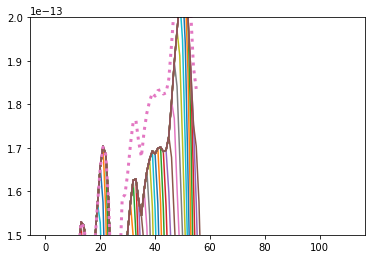

In [37]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][0].values, dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'SEA_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)
plt.ylim(1.5e-13,2.0e-13)

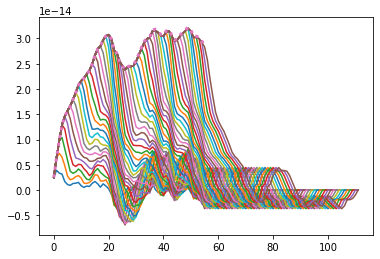

In [43]:
utils.convolve_global_mean(G_mean.sel(run = 'all_countries').compute(), ds_emis_gmean['all_countries'], dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'all_countries_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)

<xarray.DataArray (s: 112)>
array([ 1.28277446e-14,  3.62223337e-14,  5.76822234e-14,  7.72638665e-14,
        9.04643790e-14,  1.01862593e-13,  1.14089699e-13,  1.26618541e-13,
        1.38402173e-13,  1.42242655e-13,  1.38418652e-13,  1.37927428e-13,
        1.46135771e-13,  1.52956677e-13,  1.52094363e-13,  1.47661461e-13,
        1.45475822e-13,  1.42392296e-13,  1.48133953e-13,  1.57114440e-13,
        1.65617190e-13,  1.70329357e-13,  1.68536843e-13,  1.58140141e-13,
        1.40067006e-13,  1.34660863e-13,  1.34872101e-13,  1.40579591e-13,
        1.45041224e-13,  1.45954198e-13,  1.50750210e-13,  1.57305843e-13,
        1.62538884e-13,  1.62828843e-13,  1.57892070e-13,  1.54418846e-13,
        1.60322297e-13,  1.64601855e-13,  1.67393729e-13,  1.69275697e-13,
        1.68593336e-13,  1.69894659e-13,  1.70153695e-13,  1.69130962e-13,
        1.69414240e-13,  1.72648825e-13,  1.80610387e-13,  1.89610602e-13,
        1.96939499e-13,  2.03977906e-13,  2.07675600e-13,  2.06910632e-13,
        1.99979738e-13,  1.88040097e-13,  1.75333886e-13,  1.70333573e-13,
        1.57506351e-13,  1.34113166e-13,  1.12654318e-13,  9.30734883e-14,
        7.98734737e-14,  6.84759540e-14,  5.62499204e-14,  4.37220778e-14,
        3.19388136e-14,  2.80983037e-14,  3.19218932e-14,  3.24129690e-14,
        2.42051815e-14,  1.73846202e-14,  1.82468641e-14,  2.26795536e-14,
        2.48650375e-14,  2.79481689e-14,  2.22063738e-14,  1.32258848e-14,
        4.72320807e-15,  1.08961076e-17,  1.80306754e-15,  1.21991673e-14,
        3.02716066e-14,  3.56781576e-14,  3.54677266e-14,  2.97609053e-14,
        2.52987499e-14,  2.43843715e-14,  1.95873188e-14,  1.30308713e-14,
        7.79733285e-15,  7.50667998e-15,  1.24423805e-14,  1.59146046e-14,
        1.00107865e-14,  5.73125551e-15,  2.93979473e-15,  1.05797548e-15,
        1.73978071e-15,  4.38113253e-16,  1.79146884e-16,  1.20209319e-15,
        9.18969098e-16, -2.31522116e-15, -1.02766440e-14, -1.92768577e-14,
       -2.66058277e-14, -3.36440897e-14, -3.73414412e-14, -3.65758707e-14,
       -2.96442813e-14, -1.77050484e-14, -4.99964415e-15,  0.00000000e+00])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 103 104 105 106 107 108 109 110 111

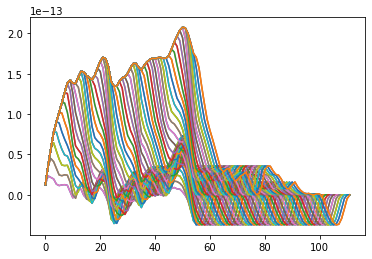

In [125]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][0].values, dt = dt)
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), ds_emis_gmean['SEA'], dt = dt)


<xarray.DataArray (s: 112)>
array([ 1.28277446e-14,  3.62223337e-14,  5.76822234e-14,  7.72638665e-14,
        9.04643790e-14,  1.01862593e-13,  1.14089699e-13,  1.26618541e-13,
        1.38402173e-13,  1.42242655e-13,  1.38418652e-13,  1.37927428e-13,
        1.46135771e-13,  1.52956677e-13,  1.52094363e-13,  1.47661461e-13,
        1.45475822e-13,  1.42392296e-13,  1.48133953e-13,  1.57114440e-13,
        1.65617190e-13,  1.70329357e-13,  1.68536843e-13,  1.58140141e-13,
        1.40067006e-13,  1.34660863e-13,  1.34872101e-13,  1.40579591e-13,
        1.45041224e-13,  1.45954198e-13,  1.50750210e-13,  1.57305843e-13,
        1.62538884e-13,  1.62828843e-13,  1.57892070e-13,  1.54418846e-13,
        1.60322297e-13,  1.64601855e-13,  1.67393729e-13,  1.69275697e-13,
        1.68593336e-13,  1.69894659e-13,  1.70153695e-13,  1.69130962e-13,
        1.69414240e-13,  1.72648825e-13,  1.80610387e-13,  1.89610602e-13,
        1.96939499e-13,  2.03977906e-13,  2.07675600e-13,  2.06910632e-13,
        1.99979738e-13,  1.88040097e-13,  1.75333886e-13,  1.70333573e-13,
        1.57506351e-13,  1.34113166e-13,  1.12654318e-13,  9.30734883e-14,
        7.98734737e-14,  6.84759540e-14,  5.62499204e-14,  4.37220778e-14,
        3.19388136e-14,  2.80983037e-14,  3.19218932e-14,  3.24129690e-14,
        2.42051815e-14,  1.73846202e-14,  1.82468641e-14,  2.26795536e-14,
        2.48650375e-14,  2.79481689e-14,  2.22063738e-14,  1.32258848e-14,
        4.72320807e-15,  1.08961076e-17,  1.80306754e-15,  1.21991673e-14,
        3.02716066e-14,  3.56781576e-14,  3.54677266e-14,  2.97609053e-14,
        2.52987499e-14,  2.43843715e-14,  1.95873188e-14,  1.30308713e-14,
        7.79733285e-15,  7.50667998e-15,  1.24423805e-14,  1.59146046e-14,
        1.00107865e-14,  5.73125551e-15,  2.93979473e-15,  1.05797548e-15,
        1.73978071e-15,  4.38113253e-16,  1.79146884e-16,  1.20209319e-15,
        9.18969098e-16, -2.31522116e-15, -1.02766440e-14, -1.92768577e-14,
       -2.66058277e-14, -3.36440897e-14, -3.73414412e-14, -3.65758707e-14,
       -2.96442813e-14, -1.77050484e-14, -4.99964415e-15,  0.00000000e+00])
Coordinates:
  * s        (s) int64 0 1 2 3 4 5 6 7 8 ... 103 104 105 106 107 108 109 110 111

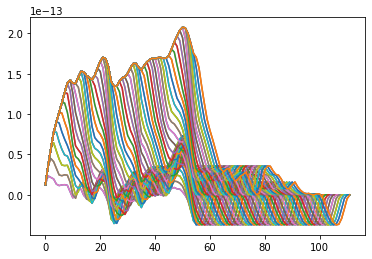

In [124]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][30].values, dt = dt)
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), ds_emis_gmean['SEA'], dt = dt)


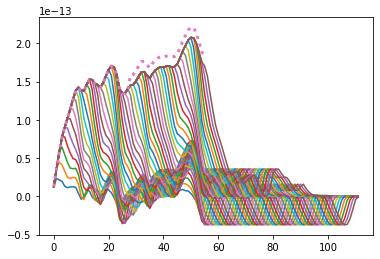

In [127]:
utils.convolve_global_mean(G_mean.sel(run = 'SEA').compute(), np.ones(len(ds_emis_gmean['SEA']))*ds_emis_gmean['SEA'][55].values, dt = dt)
plt.plot((utils.global_w_mean(ds_conc.sel(run = 'SEA_2x').fillna(0), poll_name)-
            utils.global_w_mean(ds_conc.sel(run = 'base').fillna(0), poll_name)), linestyle = ':', linewidth = 3)

array([570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 570310.08878076, 570310.08878076, 570310.08878076,
       570310.08878076, 5

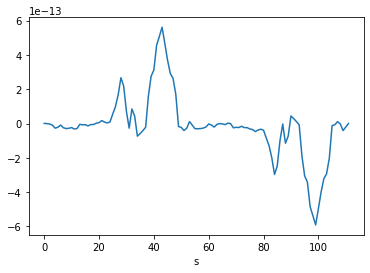

In [35]:
out_mean['SEA'].plot()